<a href="https://colab.research.google.com/github/SiLiKhon/RICH_GAN_misc/blob/master/RICH_Data_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RICH Data Overview

## Get the data

The training sample is shared [here](https://cernbox.cern.ch/index.php/s/RkZoMRBofrhqzZm).

These are simulated detector responses for 6 particle types (below are per-file links to the same files as above):



*   electrons https://cernbox.cern.ch/index.php/s/q5ZwDYfvOXJmnBR
*   kaons https://cernbox.cern.ch/index.php/s/nfBRDGCagdgor3q
*   muons https://cernbox.cern.ch/index.php/s/jfw0Nhyw8gYNBhk
*   pions https://cernbox.cern.ch/index.php/s/dyZJGMZuVRW0Kgg
*   protons https://cernbox.cern.ch/index.php/s/SQ6G6dmLOLTvMuz
*   ghosts https://cernbox.cern.ch/index.php/s/9Ui4xKerEDdw7Fv (these are 'fake' tracks - i.e. random tracker hits that look like a track from a real particle)



In [0]:
# let's download pions and kaons
!wget -O pions https://cernbox.cern.ch/index.php/s/dyZJGMZuVRW0Kgg
!wget -O kaons https://cernbox.cern.ch/index.php/s/nfBRDGCagdgor3q

def convert_to_direct_link(fname):
  def get_direct_link(fname):
    with open(fname) as f:
      lines = f.readlines()
      for l in lines:
        if 'downloadURL' in l:
          parts = l.split()
          for p in parts:
            if p[:5] == 'value':
              return p.split('"')[-2]
      raise KeyError("downloadURL not found")
  
  link = get_direct_link(fname)
  with open(fname, 'w') as f:
    f.write(link)

convert_to_direct_link('kaons')
convert_to_direct_link('pions')
!wget -O v1_pion_train.csv `cat pions`
!wget -O v1_kaon_train.csv `cat kaons`

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df_pion = pd.read_csv('v1_pion_train.csv')
df_kaon = pd.read_csv('v1_kaon_train.csv')

In [4]:
print(df_pion.columns)
print(df_kaon.columns)

Index(['TrackPt', 'TrackP', 'NumLongTracks', 'MCParticleType', 'RichDLLbt',
       'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe', 'TrackEta'],
      dtype='object')
Index(['TrackPt', 'TrackP', 'NumLongTracks', 'MCParticleType', 'RichDLLbt',
       'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe', 'TrackEta'],
      dtype='object')


Input variables are:
*   `TrackP` – full momentum of the particle
*   `TrackPt` – length of the momentum projection to the XY plane
*   `TrackEta` – track [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity)
*   `NumLongTracks` – number of reconstructed tracks in current event

Please note that among P, Pt and ETA there are only **two** independant variables. 


The variables to predict are:

*   `RichDLLbt`
*   `RichDLLk`
*   `RichDLLmu`
*   `RichDLLp`
*   `RichDLLe`


There's also one additional variable:

*   `MCParticleType` – particle [PDG code](http://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)




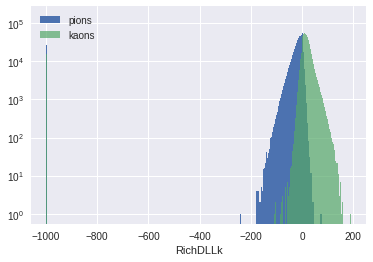

In [5]:
bins = np.linspace(
        start=min(df_pion.RichDLLk.min(), df_kaon.RichDLLk.min()), 
        stop =max(df_pion.RichDLLk.max(), df_kaon.RichDLLk.max()), 
        num=601
    )

plt.hist(df_pion.RichDLLk, bins=bins, label='pions')
plt.hist(df_kaon.RichDLLk, bins=bins, label='kaons', alpha=0.7)
plt.yscale('log')
plt.legend()
plt.xlabel('RichDLLk');

One can see there's a peak of outliers at the left handside of the plot. Let's not bother about it so far.

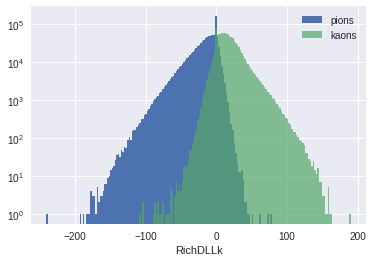

In [6]:
not_outlier_pion = df_pion.RichDLLk > -500
not_outlier_kaon = df_kaon.RichDLLk > -500

bins = np.linspace(
        start=min(df_pion.RichDLLk[not_outlier_pion].min(), df_kaon.RichDLLk[not_outlier_kaon].min()), 
        stop =max(df_pion.RichDLLk[not_outlier_pion].max(), df_kaon.RichDLLk[not_outlier_kaon].max()), 
        num=201
    )

plt.hist(df_pion.RichDLLk, bins=bins, label='pions')
plt.hist(df_kaon.RichDLLk, bins=bins, label='kaons', alpha=0.7)
plt.yscale('log')
plt.legend()
plt.xlabel('RichDLLk');

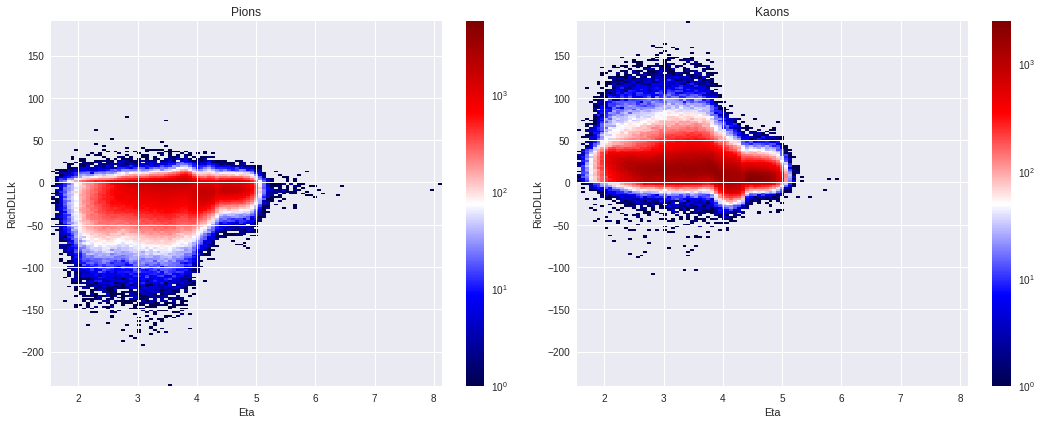

In [7]:
import matplotlib.colors as colors

fig, (ax_pion, ax_kaon) = plt.subplots(
                                    nrows=1,
                                    ncols=2,
                                    figsize=(15, 6)
                                )

_, bins_x, bins_y, img_pion = \
    ax_pion.hist2d(
            x=df_pion.TrackEta,
            y=df_pion.RichDLLk,
            bins=(100, bins),
            cmap='seismic',
            norm=colors.LogNorm()
        )
_, _, _, img_kaon = \
    ax_kaon.hist2d(
            x=df_kaon.TrackEta,
            y=df_kaon.RichDLLk,
            bins=(bins_x, bins_y),
            cmap='seismic',
            norm=colors.LogNorm()
        )

plt.colorbar(img_pion, ax=ax_pion)
plt.colorbar(img_kaon, ax=ax_kaon)
ax_pion.set_xlabel('Eta')
ax_kaon.set_xlabel('Eta')
ax_pion.set_ylabel('RichDLLk')
ax_kaon.set_ylabel('RichDLLk')
ax_pion.set_title('Pions')
ax_kaon.set_title('Kaons')
fig.tight_layout();

# The simplest model possible

In [0]:
class Model:
    def train(self, X, Y):
        self.means = {}
        self.stds = {}
        for col in Y.columns:
            self.means[col] = np.mean(Y[col])
            self.stds [col] = np.std (Y[col])

    def predict(self, X):
        prediction = pd.DataFrame()
        for col in self.means.keys():
            prediction[col] = np.random.normal(
                                loc=self.means[col],
                                scale=self.stds[col],
                                size=len(X)
                            )
        return prediction

In [0]:
from sklearn.model_selection import KFold
from scipy.stats import ks_2samp

In [0]:
x_cols = ['TrackP', 'TrackEta', 'NumLongTracks']
y_cols = ['RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']


def score_func(sample1, sample2):
  score = 0
  
  # at first, let's ignore X
  for col in y_cols:
    score += ks_2samp(sample1[col], sample2[col])[0]
  return score

In [0]:
kf = KFold(n_splits=5)

model_scores = []
best_scores  = []

for train_index, test_index in kf.split(df_pion[x_cols]):
  X_train = df_pion[x_cols].iloc[train_index]
  Y_train = df_pion[y_cols].iloc[train_index]
  X_test  = df_pion[x_cols].iloc[test_index ]
  Y_test  = df_pion[y_cols].iloc[test_index ]
  
  model = Model()
  model.train(X_train[sel_pion[train_index]], Y_train[sel_pion[train_index]])
  Y_pred = model.predict(X_test)
  
  model_scores.append(score_func(Y_test, Y_pred ))
  best_scores .append(score_func(Y_test, Y_train))

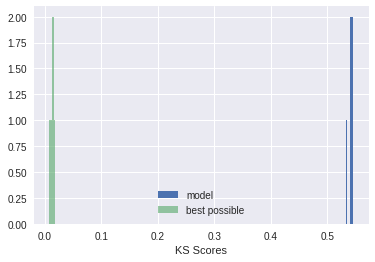

In [12]:
bins = np.linspace(
            start=min(model_scores + best_scores), 
            stop =max(model_scores + best_scores), 
            num=201
        )

plt.hist(model_scores, bins=bins, label='model')
plt.hist(best_scores , bins=bins, label='best possible', alpha=0.6)
plt.legend()
plt.xlabel('KS Scores');

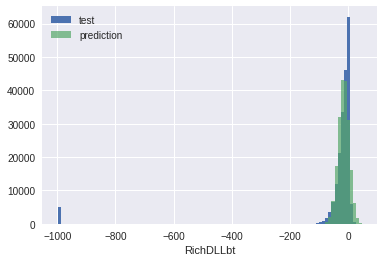

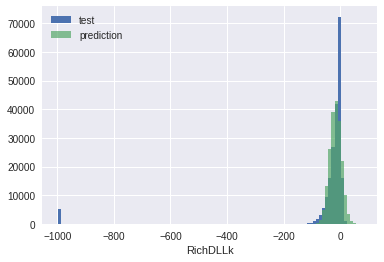

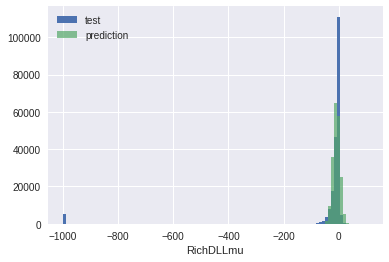

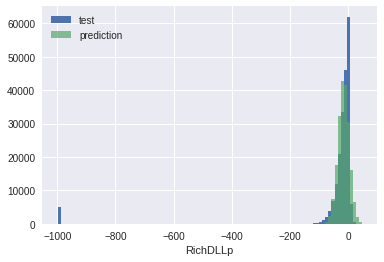

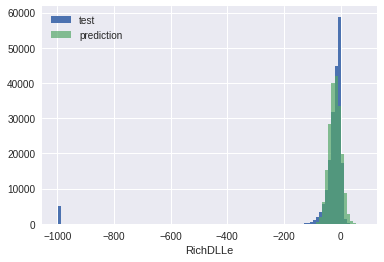

In [13]:
for col in Y_pred.columns:
  _, bins, _ = plt.hist(Y_test[col], bins=100 , label='test'      )
  _, _   , _ = plt.hist(Y_pred[col], bins=bins, label='prediction', alpha=0.7)
  plt.legend()
  plt.xlabel(col)
  plt.show();